In [79]:
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def score_classifier(dataset,
                     classifier,
                     labels,
                     nb_splits:int=3
                     ):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=nb_splits,
               random_state=50,
               shuffle=True
               )
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=nb_splits

    return confusion_mat, recall

In [42]:
from typing import Union, List
import re
import unidecode

def ts_slugify(ts : Union[str, pd.Series]):
    # slugify a pandas series or a string
    # remove special characters, accents and spaces
    # replace spaces by underscores
    # convert to lower case
    # it's a bit slow
    # TODO : use np.vectorize to make it faster
    if isinstance(ts, pd.Series):
        ts = ts.str.lower().str.replace(' ', '_')
        ts = ts.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        ts = ts.str.replace(pat="[^0-9A-z%_-]+", repl='', regex=True)
        ts = ts.str.replace(pat="['\\\\']", repl='', regex=True)
        return ts.str.strip('_')
    if isinstance(ts, str):
        string = ts.lower().replace(' ', '_')
        #replace % by percent
        string = string.replace('%', '_pca')
        string = unidecode.unidecode(string)
        string = re.sub('[^0-9A-z%_-]+', '', string)
        string = re.sub("['\\\\']", '', string)
        return string.strip('_')

In [43]:
!pwd

/Users/ramansheshka/code/test_datascience_mpdata/notebooks


In [44]:
#parent directory
parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)


/Users/ramansheshka/code/test_datascience_mpdata


In [45]:
# Load dataset
df_raw = pd.read_csv(os.path.join(parent_dir,"data_test","nba_logreg.csv"))

In [46]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

In [47]:
raw_columns_list = df_raw.columns.tolist()
print(raw_columns_list)
slug_columns_list = [ts_slugify(s) for s in raw_columns_list]
print(slug_columns_list)
#rename columns
df_raw.columns = slug_columns_list

['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs']
['name', 'gp', 'min', 'pts', 'fgm', 'fga', 'fg_pca', '3p_made', '3pa', '3p_pca', 'ftm', 'fta', 'ft_pca', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'target_5yrs']


In [48]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1340 non-null   object 
 1   gp           1340 non-null   int64  
 2   min          1340 non-null   float64
 3   pts          1340 non-null   float64
 4   fgm          1340 non-null   float64
 5   fga          1340 non-null   float64
 6   fg_pca       1340 non-null   float64
 7   3p_made      1340 non-null   float64
 8   3pa          1340 non-null   float64
 9   3p_pca       1329 non-null   float64
 10  ftm          1340 non-null   float64
 11  fta          1340 non-null   float64
 12  ft_pca       1340 non-null   float64
 13  oreb         1340 non-null   float64
 14  dreb         1340 non-null   float64
 15  reb          1340 non-null   float64
 16  ast          1340 non-null   float64
 17  stl          1340 non-null   float64
 18  blk          1340 non-null   float64
 19  tov   

It's a relatively small datase, only 1.5K rows, so no DL. i will be able to converge custom made regressor, havy fir asked problem. so pure ML.
Target is ```target_5yrs columns``` : takes 0 or 1, so classification problem.

In [49]:
df_raw.sample(5)

name  gp   min   pts  fgm   fga  fg_pca  3p_made  3pa  3p_pca  \
40    Kevin Lynch  55  14.9   4.1  1.7   4.1    41.7      0.1  0.1    37.5   
545  Mike Gminski  56  28.2  13.2  5.2  12.3    42.3      0.0  0.0     0.0   
255  Ricky Wilson  24  17.5   5.2  1.8   4.6    39.1      0.4  1.1    38.5   
353  Vern Fleming  80  31.1  14.1  5.4  11.5    47.0      0.0  0.1     0.0   
3     Malik Sealy  58  11.6   5.7  2.3   5.5    42.6      0.1  0.5    22.6   

     ...  fta  ft_pca  oreb  dreb  reb  ast  stl  blk  tov  target_5yrs  
40   ...  0.8    76.1   0.5   1.0  1.5  1.5  0.7  0.2  0.8          0.0  
545  ...  3.6    76.7   2.4   5.0  7.5  1.3  1.0  1.8  2.3          1.0  
255  ...  1.7    72.5   0.1   1.0  1.1  2.9  1.0  0.1  1.0          0.0  
353  ...  4.2    76.7   1.9   2.2  4.0  3.1  1.2  0.1  2.5          1.0  
3    ...  1.3    68.9   1.0   0.9  1.9  0.8  0.6  0.1  1.0          1.0  

[5 rows x 21 columns]

In [53]:
df_raw.describe()

gp          min          pts          fgm          fga  \
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000   
mean     60.414179    17.624627     6.801493     2.629104     5.885299   
std      17.433992     8.307964     4.357545     1.683555     3.593488   
min      11.000000     3.100000     0.700000     0.300000     0.800000   
25%      47.000000    10.875000     3.700000     1.400000     3.300000   
50%      63.000000    16.100000     5.550000     2.100000     4.800000   
75%      77.000000    22.900000     8.800000     3.400000     7.500000   
max      82.000000    40.900000    28.200000    10.200000    19.800000   

            fg_pca      3p_made          3pa       3p_pca          ftm  \
count  1340.000000  1340.000000  1340.000000  1329.000000  1340.000000   
mean     44.169403     0.247612     0.779179    19.308126     1.297687   
std       6.137679     0.383688     1.061847    16.022916     0.987246   
min      23.800000     0.000000     0.000000     0.000000     0.000000   
25%      40.200000     0.000000     0.000000     0.000000     0.600000   
50%      44.100000     0.100000     0.300000    22.400000     1.000000   
75%      47.900000     0.400000     1.200000    32.500000     1.600000   
max      73.700000     2.300000     6.500000   100.000000     7.700000   

               fta       ft_pca         oreb         dreb          reb  \
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000   
mean      1.821940    70.300299     1.009403     2.025746     3.034478   
std       1.322984    10.578479     0.777119     1.360008     2.057774   
min       0.000000     0.000000     0.000000     0.200000     0.300000   
25%       0.900000    64.700000     0.400000     1.000000     1.500000   
50%       1.500000    71.250000     0.800000     1.700000     2.500000   
75%       2.300000    77.600000     1.400000     2.600000     4.000000   
max      10.200000   100.000000     5.300000     9.600000    13.900000   

               ast          stl          blk          tov  target_5yrs  
count  1340.000000  1340.000000  1340.000000  1340.000000  1340.000000  
mean      1.550522     0.618507     0.368582     1.193582     0.620149  
std       1.471169     0.409759     0.429049     0.722541     0.485531  
min       0.000000     0.000000     0.000000     0.100000     0.000000  
25%       0.600000     0.300000     0.100000     0.700000     0.000000  
50%       1.100000     0.500000     0.200000     1.000000     1.000000  
75%       2.000000     0.800000     0.500000     1.500000     1.000000  
max      10.600000     2.500000     3.900000     4.400000     1.000000

In [63]:
#nan values
df_raw.isna().sum()

name            0
gp              0
min             0
pts             0
fgm             0
fga             0
fg_pca          0
3p_made         0
3pa             0
3p_pca         11
ftm             0
fta             0
ft_pca          0
oreb            0
dreb            0
reb             0
ast             0
stl             0
blk             0
tov             0
target_5yrs     0
dtype: int64

In [70]:
# replacing Nan values (only present when no 3 points attempts have been performed by a player)
column_name = '3p_pca'
array = df_raw[column_name].values
array_clean = np.nan_to_num(array,
                            nan=0.0
                            )
df_clean = df_raw.copy()
df_clean[column_name] = array_clean
#for x in np.argwhere(np.isnan(df_vals)):
#    df_vals[x]=0.0

In [74]:
all_features = df_raw.columns.tolist()
all_features.remove('name')
all_features.remove('target_5yrs')
print(all_features)
df_clean.groupby(by=['target_5yrs'])[all_features].mean()

['gp', 'min', 'pts', 'fgm', 'fga', 'fg_pca', '3p_made', '3pa', '3p_pca', 'ftm', 'fta', 'ft_pca', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov']


gp        min       pts       fgm       fga     fg_pca  \
target_5yrs                                                                  
0.0          51.577603  14.252259  5.042829  1.946169  4.542043  42.388802   
1.0          65.826715  19.690253  7.878700  3.047413  6.708063  45.260048   

              3p_made       3pa     3p_pca       ftm       fta     ft_pca  \
target_5yrs                                                                 
0.0          0.229666  0.754617  19.149705  0.923379  1.321611  68.858546   
1.0          0.258604  0.794224  19.149579  1.526955  2.128400  71.183394   

                 oreb      dreb       reb       ast       stl       blk  \
target_5yrs                                                               
0.0          0.718271  1.531238  2.247544  1.221022  0.498232  0.253438   
1.0          1.187726  2.328640  3.516486  1.752347  0.692178  0.439110   

                  tov  
target_5yrs            
0.0          0.942240  
1.0          1.347533

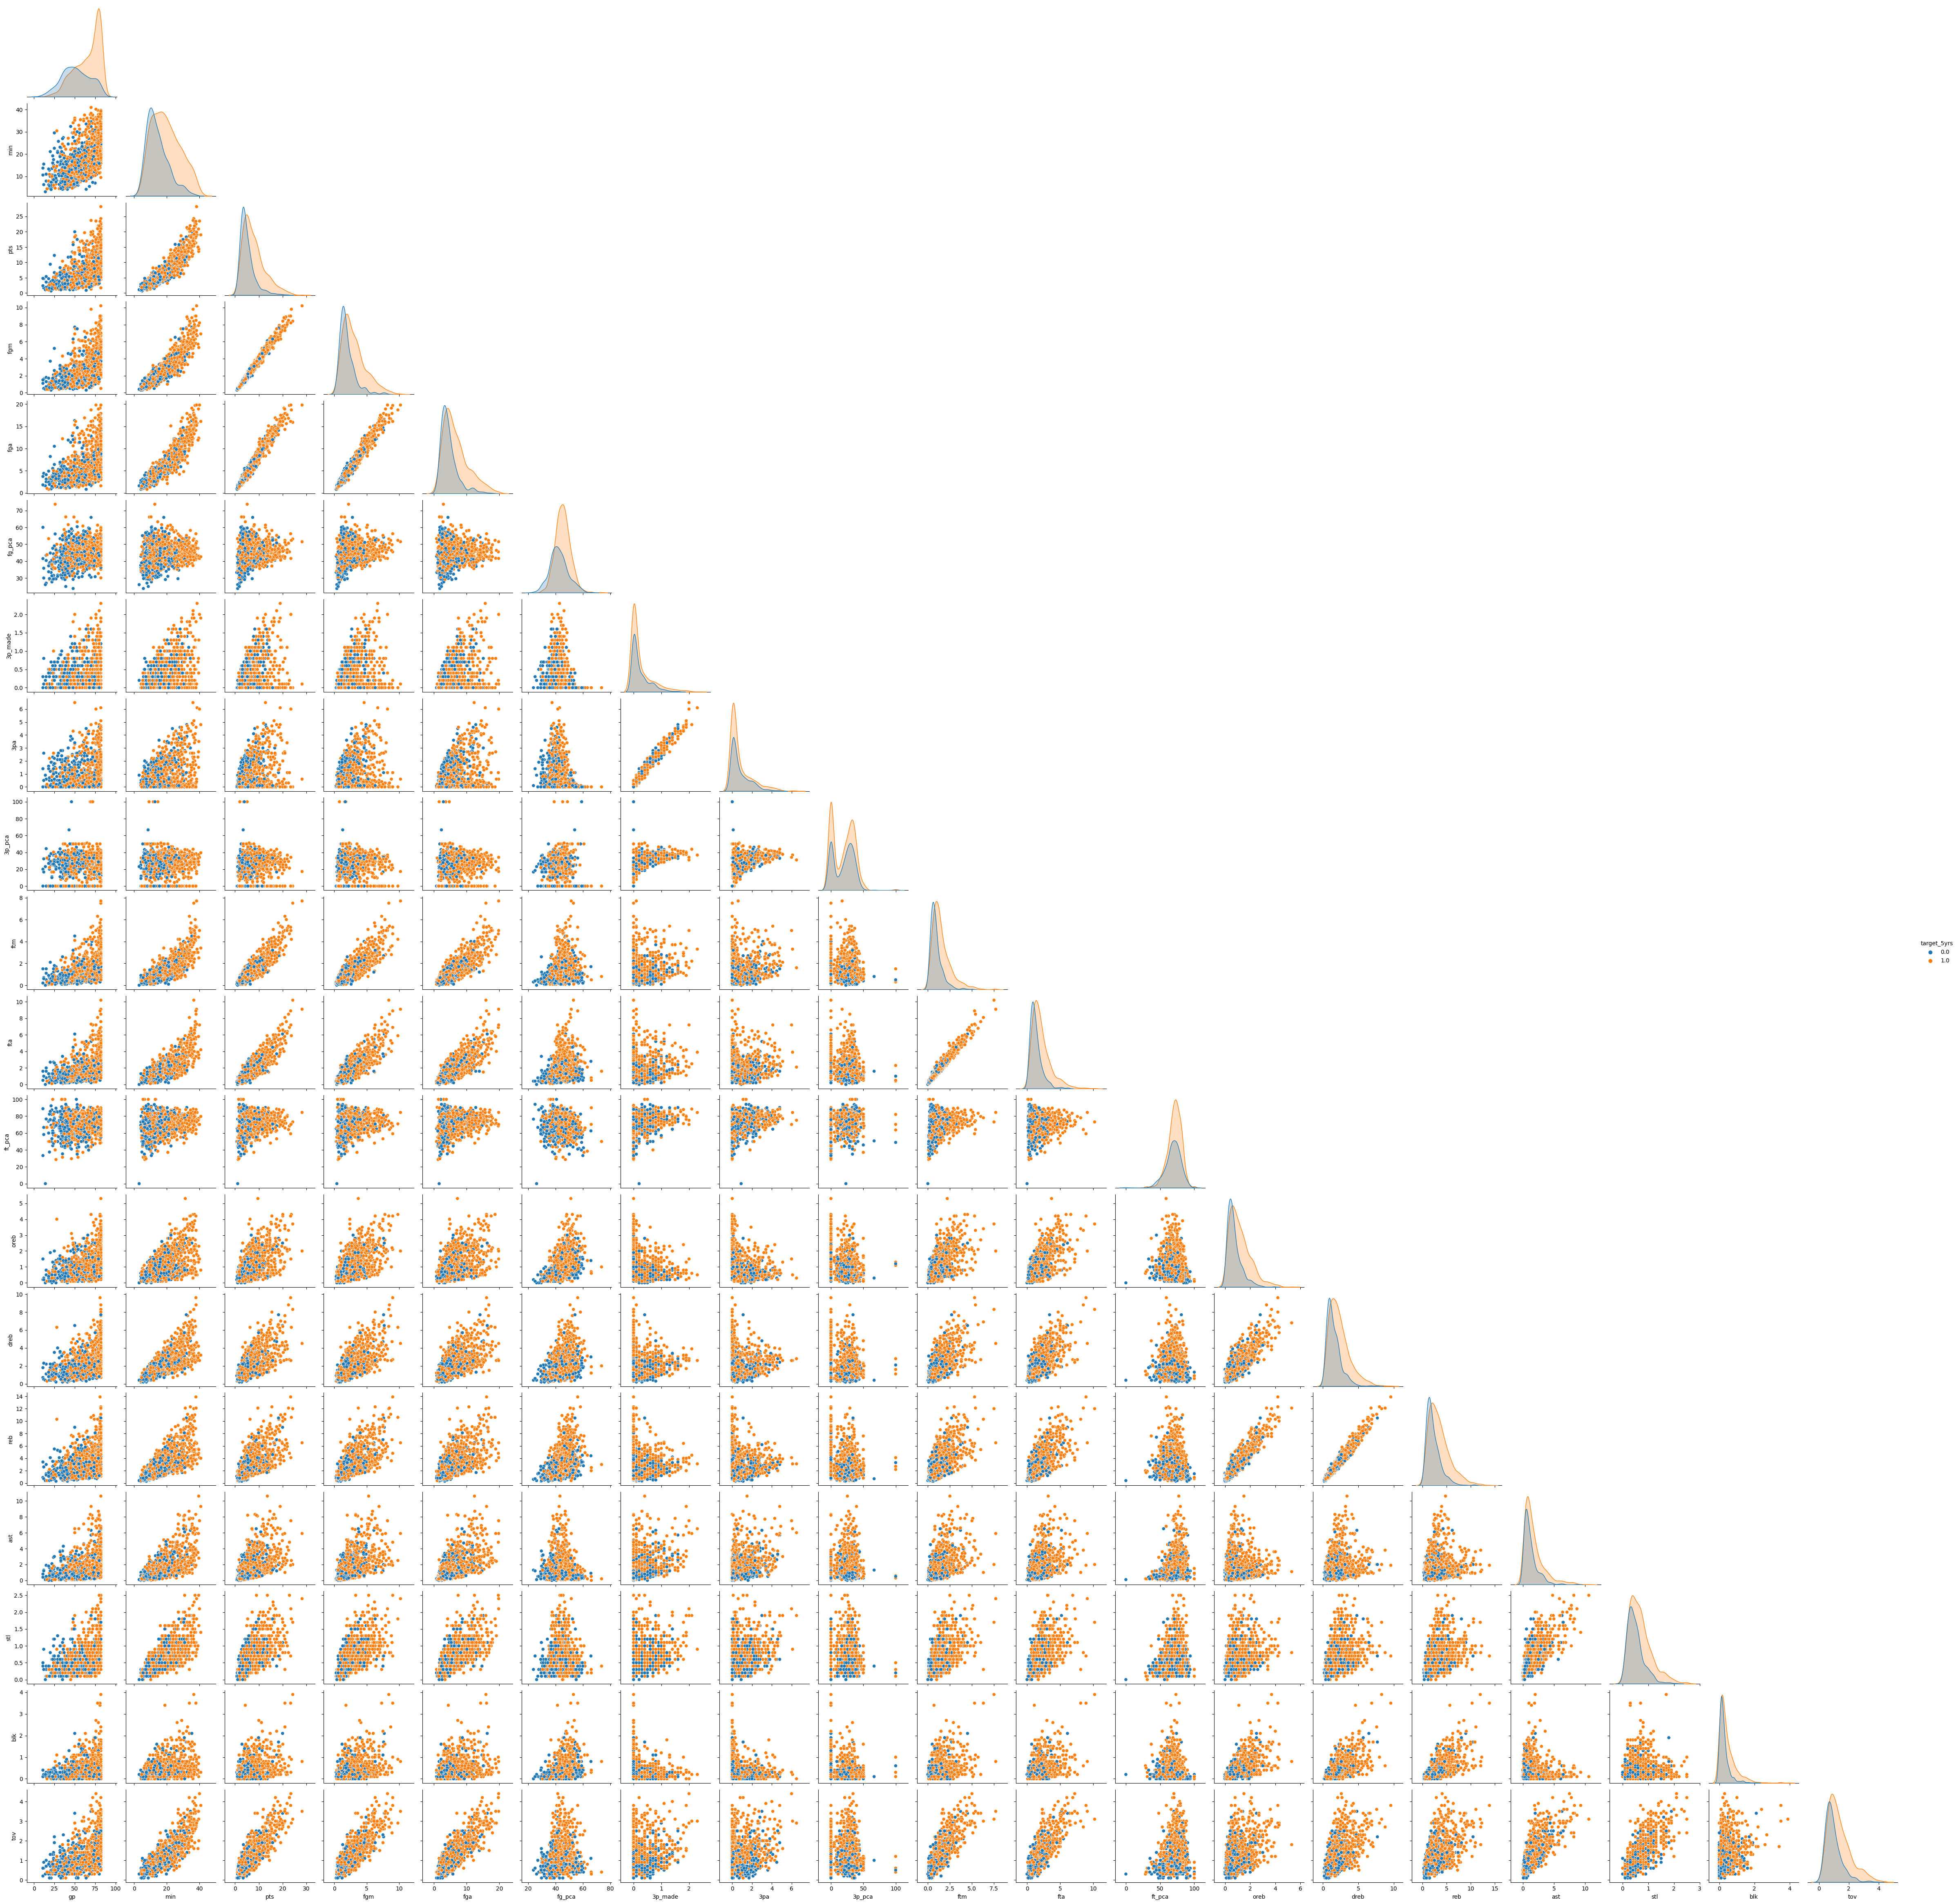

In [73]:
import seaborn as sns

sns.pairplot(df_clean,
             hue='target_5yrs',
             diag_kind='kde',
             corner=True,
             )

In [75]:
#correlation matrix
corr = df_clean[all_features].corr()

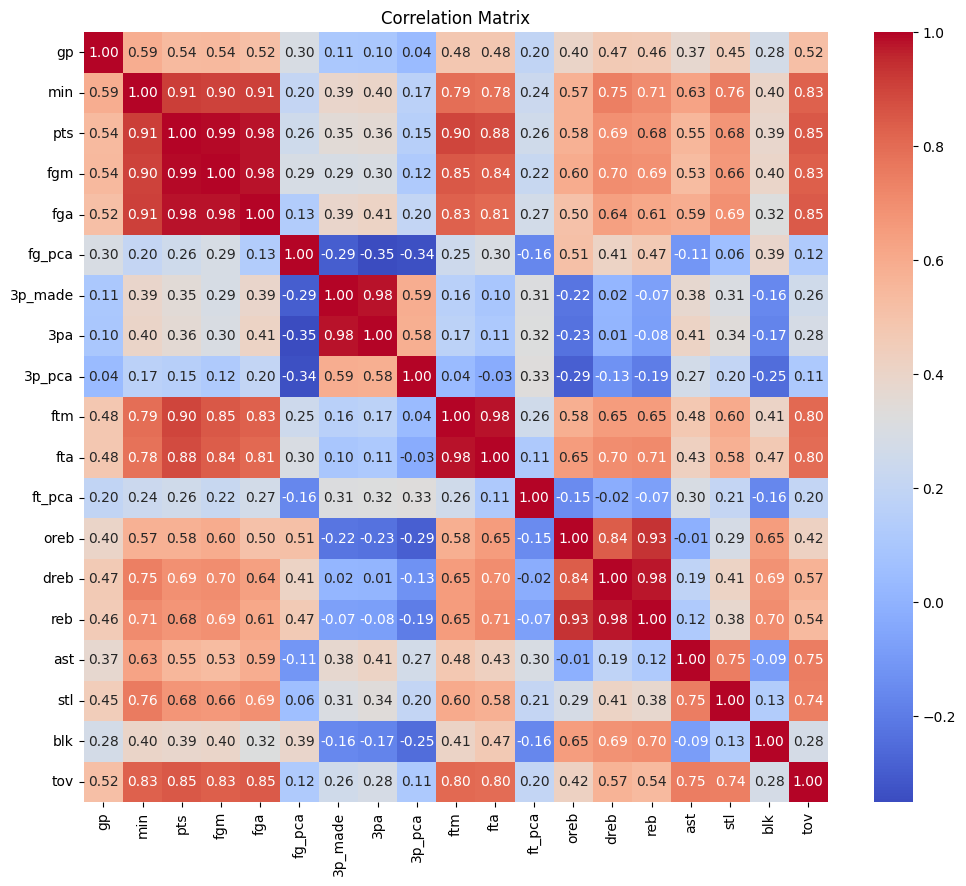

In [76]:
# visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr,
            annot=True,
            cmap='coolwarm',
            fmt=".2f"
            )
plt.title("Correlation Matrix")
plt.show()

<AxesSubplot:>

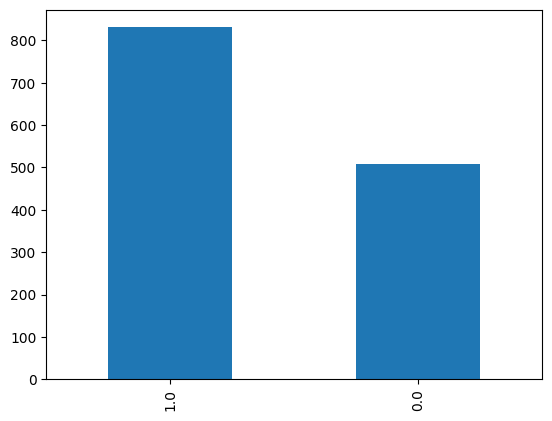

In [77]:
df_clean['target_5yrs'].value_counts()

# bar plot of target_5yrs
df_clean['target_5yrs'].value_counts().plot(kind='bar')

In [80]:
df = df_clean.copy()

In [84]:
# extract names, labels, features names and values
names = df['name'].values.tolist() # players names
labels = df['target_5yrs'].values # labels
paramset = df.drop(['target_5yrs','name'],axis=1).columns.values
df_vals = df.drop(['target_5yrs','name'],axis=1).values

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
#for x in np.argwhere(np.isnan(df_vals)):
#    df_vals[x]=0.0

# normalize dataset
X = MinMaxScaler().fit_transform(df_vals)
y = labels

### baseline model

In [86]:
#example of scoring with support vector classifier
model_confusion_matrix,model_recal = score_classifier(X,
                                                      SVC(),
                                                      y
                                                      )

print(model_confusion_matrix)
print(model_recal)
#from sklearn.metrics import ConfusionMatrixDisplay


[[269. 240.]
 [146. 685.]]
0.8243162205866037
